In [1]:
import sys
import pandas as pd
import numpy as np
import glob
import seaborn as sns
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')
sys.path.append("../Moduulit/modules")
sys.path.append("../Datat/Mittaukset")
sys.path.append("../Datat/koskemattomat_csv")
sys.path.append("../Datat/csv")

### Luetaan uusista datoista muodostettu .csv tiedosto Pandasin Dataframeen.

In [2]:
df = pd.read_csv("../Datat/uudet/csv/uusi_df.csv")

amounts = {}
amounts["Alussa"] = len(df)

#### Tarkastellaan miltä value sarakkeiden kuvaajat näyttävät.

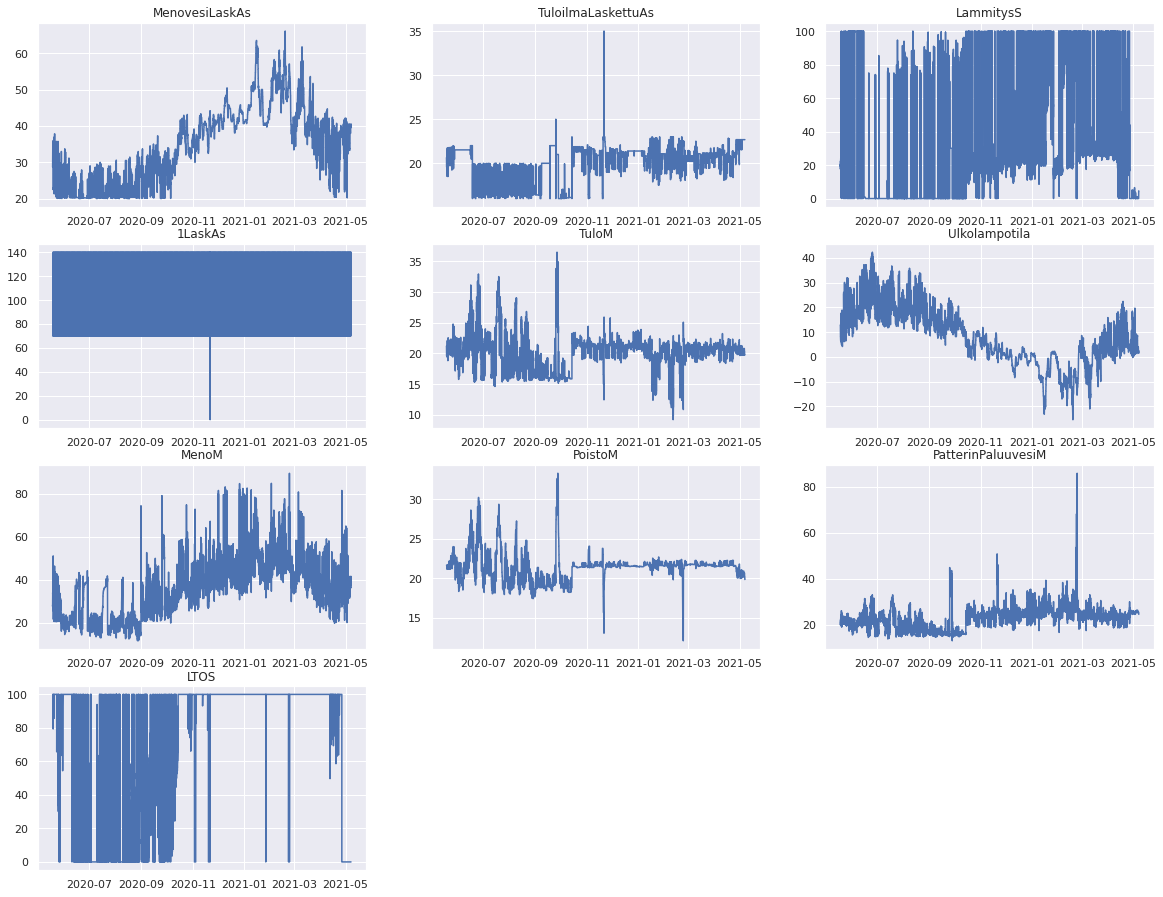

In [3]:
from check_plot import check_plot
check_plot(df)

Kuvaajista nähdään, että ilmanvaihtokone on ollut hetken sammuksissa. Se on oletettavasti aiheuttanut hetkellisiä piikkejä TuloilmaLaskAs-, TuloM- ja PoistoM-sarakkeisiin.
Useissa muissakin value-sarakkeissa on hetkellisiä piikkejä, jotka oletettavasti johtuu lämpötilan nopeasti laskemisesta.
Päätimme, että poistamme kaikki piikit datasta, jos ne ovat yli kolmen keskihajonnan päästä muista sarakkeiden arvoista. 
Tulimme tähän päätökseen, koska ennustusmallia tullaan oletettavasti käyttämään siten, että se osaa ennakoida kuinka järjestelmää tulee säätää ilmanlämpötilaennusteiden pohjalta,
jolloin tälläisiä äkillisiä säätömuutoksia ei pitäisi päästä tapahtumaan. Arvojen poistaminen myös johtaa datan tasaisenpaan jakautumiseen, joka edesauttaa ennustusmallin oppimista.

#### Poistetaan kelvotonta ja virheellistä dataa Adconsys:iltä saamien ohejiden mukaisesti.

### Poistetaan rivit, jolloin ilmanvaihtokone on ollut sammuksissa. (TK1_TF1_PE1_1_LaskAs == 0)


In [4]:
from LaskAs_drop import laskas_drop
df = laskas_drop(df)
amounts["Kone Sammuksissa"] = len(df)


All rows:  (1116953, 31)

Checking the column 'value_1LaskAs' for NaN values:  0

Checking the rows for 0 values:  (5, 31)

-----------------------------------------
Removing all rows that contain a 0 value
-----------------------------------------

New all rows:  (1116948, 31)

Done in 0.53 seconds


### Datasta poistetaan kaikki rivit, jolloin venttiili TV1.1 on kiinni.

In [5]:
from LTOS_value_drop import value_siivous
df = value_siivous(df)
amounts["LTO < 100"] = len(df)

rows at the start:  1116948
check how many NaN values there are and remove them:  0
remove all rows where value_LTOS is under 100
rows after operation:  672567


### Poistetaan kaikki muut arvot paitsi ok kaikista status-sarakkeista, paitsi lask_as arvoihin jätetään overriddenit myös.

In [6]:
from check_status import checkstatus
df = checkstatus(df)
amounts["Virheelliset Statukset"] = len(df)

Checking all status-columns...

DataFrame's shape before operation: (672567, 31) 


------------------------

Column: status_MenovesiLaskAs
Values: ['{ok}']
Dropping {overridden} -rows...

------------------------

Column: status_TuloilmaLaskettuAs
Values: ['{ok}' '{overridden}']

------------------------

Column: status_LammitysS
Values: ['{ok}' '{fault}']
Dropping {fault} -rows...

------------------------

Column: status_1LaskAs
Values: ['{ok}']

------------------------

Column: status_TuloM
Values: ['{ok}' '{fault}' '{down}']
Dropping {fault} -rows...
Dropping {down} -rows...

------------------------

Column: status_Ulkolampotila
Values: ['{ok}' '{fault}']
Dropping {fault} -rows...

------------------------

Column: status_MenoM
Values: ['{ok}' '{fault}']
Dropping {fault} -rows...

------------------------

Column: status_PoistoM
Values: ['{ok}' '{fault}' '{down}']
Dropping {fault} -rows...
Dropping {down} -rows...

------------------------

Column: status_PatterinPaluuvesiM
Valu

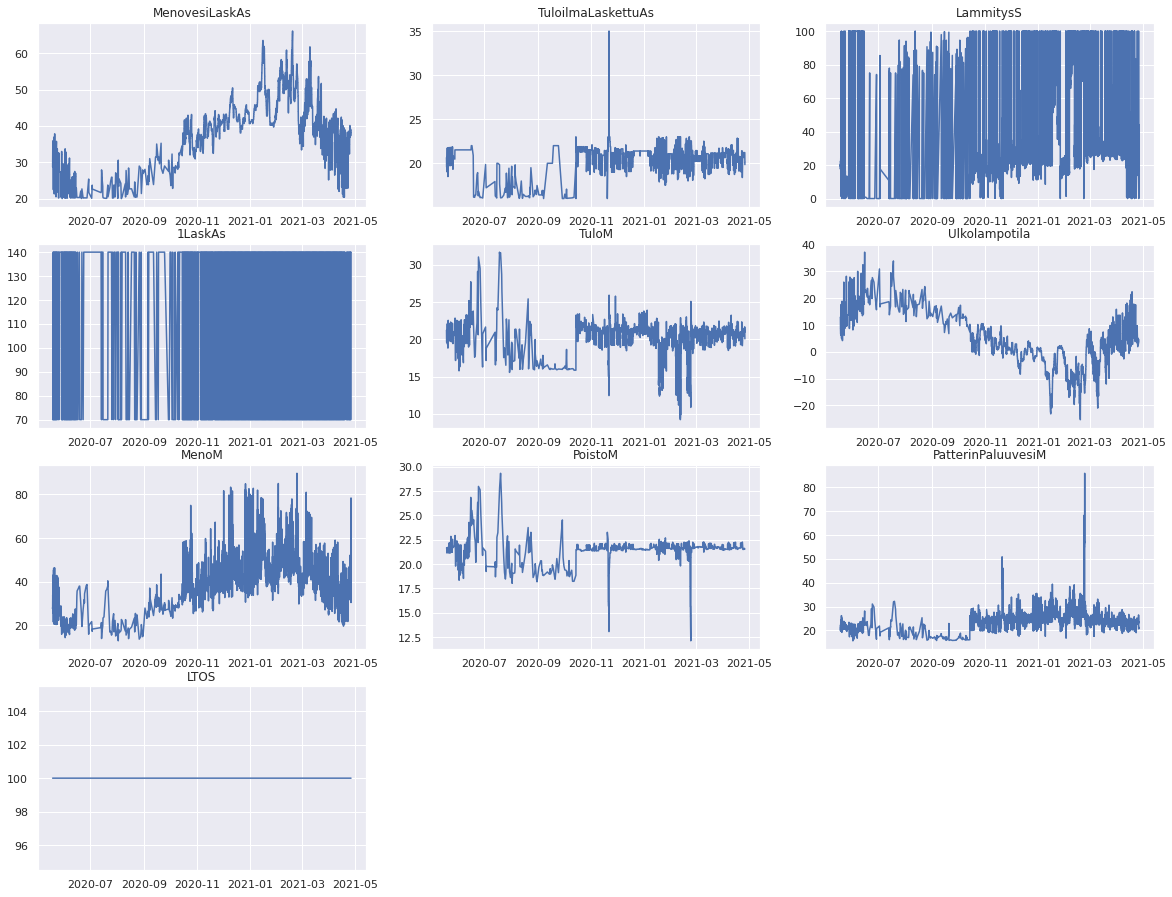

In [7]:
check_plot(df)

### Poistetaan outlier-piikit.

In [8]:
from scipy.stats import zscore
z_scores = zscore(df[["value_PatterinPaluuvesiM","value_PoistoM"]])

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df = df[filtered_entries]

amounts["Outlierit"] = len(df)

### Normalisoidaan piirre-sarakkeet

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df.drop(columns=["value_LTOS"], inplace=True)
value_columns = []
for col in df.columns:
    if "value" in col and "MenovesiLaskAs" not in col:
        value_columns.append(col)
scaler.fit(df[value_columns])

df[value_columns] = scaler.transform(df[value_columns])
df

,timestamp,trendFlags_MenovesiLaskAs,status_MenovesiLaskAs,value_MenovesiLaskAs,trendFlags_TuloilmaLaskettuAs,status_TuloilmaLaskettuAs,value_TuloilmaLaskettuAs,trendFlags_LammitysS,status_LammitysS,value_LammitysS,...,status_MenoM,value_MenoM,trendFlags_PoistoM,status_PoistoM,value_PoistoM,trendFlags_PatterinPaluuvesiM,status_PatterinPaluuvesiM,value_PatterinPaluuvesiM,trendFlags_LTOS,status_LTOS
0,2020-05-18 20:30:00,{ },{ok},28.65,{ },{ok},0.662857,{ },{ok},0.2230,...,{ok},0.227437,{ },{ok},0.520057,{ },{ok},0.279356,{ },{ok}
1,2020-05-18 20:30:00,{ },{ok},28.65,{ },{ok},0.662857,{ },{ok},0.2230,...,{ok},0.220355,{ },{ok},0.520057,{ },{ok},0.279356,{ },{ok}
2,2020-05-18 20:31:00,{ },{ok},28.65,{ },{ok},0.662857,{ },{ok},0.2230,...,{ok},0.212163,{ },{ok},0.520057,{ },{ok},0.279356,{ },{ok}
3,2020-05-18 20:31:00,{ },{ok},28.65,{ },{ok},0.662857,{ },{ok},0.2230,...,{ok},0.202583,{ },{ok},0.520057,{ },{ok},0.279356,{ },{ok}
4,2020-05-18 20:31:00,{ },{ok},28.65,{ },{ok},0.662857,{ },{ok},0.2230,...,{ok},0.213829,{ },{ok},0.520057,{ },{ok},0.279356,{ },{ok}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672562,2021-04-26 10:55:00,{start},{ok},37.34,{start},{ok},0.550000,{ },{ok},0.3681,...,{ok},0.747154,{ },{ok},0.505731,{ },{ok},0.241204,{start},{ok}
672563,2021-04-26 10:55:00,{start},{ok},37.34,{start},{ok},0.550000,{ },{ok},0.3681,...,{ok},0.864343,{ },{ok},0.505731,{start},{ok},0.210259,{start},{ok}
672564,2021-04-26 10:55:00,{start},{ok},37.34,{start},{ok},0.550000,{ },{ok},0.3681,...,{ok},0.864343,{ },{ok},0.505731,{ },{ok},0.241204,{start},{ok}
672565,2021-04-26 10:55:00,{start},{ok},37.34,{start},{ok},0.550000,{ },{ok},0.3681,...,{ok},0.906415,{ },{ok},0.505731,{start},{ok},0.210259,{start},{ok}


### Tallennetaan MinMaxScaler

In [10]:
value_columns

['value_TuloilmaLaskettuAs',
 'value_LammitysS',
 'value_1LaskAs',
 'value_TuloM',
 'value_Ulkolampotila',
 'value_MenoM',
 'value_PoistoM',
 'value_PatterinPaluuvesiM']

In [11]:
from pickle import dump, load
dump(scaler, open('../Mallit/scaler.pkl', 'wb'))
# scaler = load(open('../Mallit/scaler.pkl', 'rb'))

In [12]:
df[value_columns]

,value_TuloilmaLaskettuAs,value_LammitysS,value_1LaskAs,value_TuloM,value_Ulkolampotila,value_MenoM,value_PoistoM,value_PatterinPaluuvesiM
0,0.662857,0.2230,0.0,0.723494,0.661879,0.227437,0.520057,0.279356
1,0.662857,0.2230,0.0,0.723494,0.661879,0.220355,0.520057,0.279356
2,0.662857,0.2230,0.0,0.723494,0.661879,0.212163,0.520057,0.279356
3,0.662857,0.2230,0.0,0.723494,0.661879,0.202583,0.520057,0.279356
4,0.662857,0.2230,0.0,0.723494,0.661879,0.213829,0.520057,0.279356
...,...,...,...,...,...,...,...,...
672562,0.550000,0.3681,1.0,0.654217,0.517391,0.747154,0.505731,0.241204
672563,0.550000,0.3681,1.0,0.654217,0.517391,0.864343,0.505731,0.210259
672564,0.550000,0.3681,1.0,0.654217,0.517391,0.864343,0.505731,0.241204
672565,0.550000,0.3681,1.0,0.654217,0.517391,0.906415,0.505731,0.210259


##### Halutessa voidaan poistaa lämmityksen säädössä olevat selvät piikit, sekä loput kesäkuukausina olevat rivit.
##### Tämä vaihe on tehty over_clean -datalle. 

##### Tarkoituksena oli verrata, olisiko puhtaammalla datalla edesauttavia vaikutuksia ennustusmallin oppimiseen.
##### Ja jos olisi ollut, olisiko sen perusteella voitu tehdä joitain muutoksia siihen, miten/mitä dataa ilmanvaihtosysteemistä kerätään.


In [13]:
# from spikes import remove_lammitysS_spikes
# df = remove_lammitysS_spikes(df)
# from delete_months import delete_summer_months
# df = delete_summer_months(df)

### Poistetaan duplikaatit datasta

In [14]:
print(len(df))
df.drop_duplicates(inplace=True)
df.reset_index(drop=True)
print(len(df))
amounts["Duplikaatit"] = len(df)

648582
642011


### Siivottujen value-sarakkeiden kuvaajat.

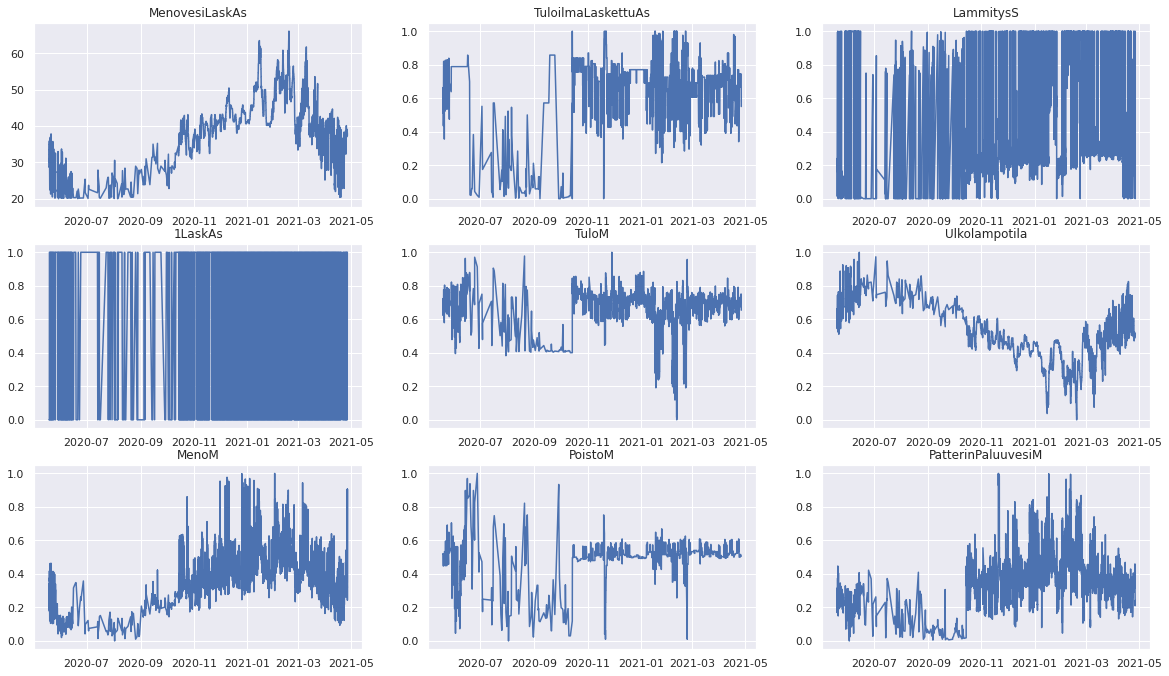

In [15]:
check_plot(df)

Datasta on nyt poistettu kelvoton data, sekä selvät outlier-piikit. Datasta on myös normalisoitu ennustuksessa käytettävät piirteet. 

Ennustettava MenovesiLaskAs-sarake on jätetty alkuperäiseen skaalaan, koska näin ennustusmallin tulos saadaan suoraan oikeassa skaalassa pihalle.
Sekin on toki mahdollista normalisoida, mutta sille pitäisi luoda oma skaaleri, jotta ennustettu arvo voidaan muuttaa takaisin alkuperäiseen skaalaan.
Jos ennustusmallina käytettäisiin luokittelevaa mallia, joka palauttaa diskreettejä arvoja joidenkin tiettyjen välien mukaan, on datan normalisointi luokiteltavaa, 
sillä silloin mallin output-kerrokseen on helpompi määritellä oikea määrä neuroneita. 

MenovesiLaskAs-sarakkeessa on tällä hetkellä arvoja välillä 20-66. 
Jos tällä alkuperäisessa skaalassa olevalla datalla tehdään luokittelevaa ennustamista, täytyy ulostuloneuroneita olla suurimpaan ennustettavaan arvoon saakka, eli tässä tapauksessa tuo 66.
Tämä johtuu siitä, että neuroverkko tulkitsee arvot omiksi luokikseen. Eli meillä on luokkia 0-66, vaikka halutaan ennustaa vain 46 eri luokkaa.

### Tarkastellaan vielä, kuinka monta riviä dataa on jäljellä jokaisen eri puhdistusoperaation jälkeen.

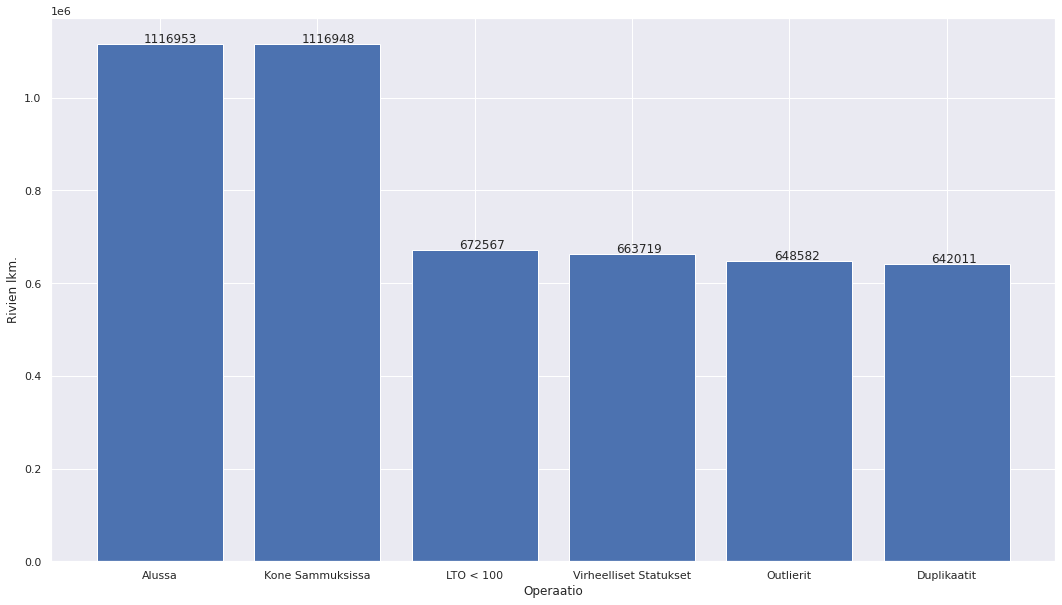

In [16]:
import matplotlib.pyplot as plt
dataa = pd.DataFrame(amounts.items(), columns=["Operaatio", "Rivimaara"])
dataa.index = dataa.Operaatio
plt.figure(figsize=(18,10))

plt.bar(dataa.index, dataa.Rivimaara);
for i in range(len(dataa.Rivimaara)):
    plt.annotate(dataa.Rivimaara[i], (-0.1 + i, dataa.Rivimaara[i] + 2000))
plt.xlabel("Operaatio");
plt.ylabel("Rivien lkm.");

### Poistetaan ylimääräiset sarakkeet 

In [17]:
from drop_columns import drop_columns
df = drop_columns(df)

-------------------------------------------------------------
---------------- Removing useless columns -------------------
-------------------------------------------------------------


 Dataframe now:



,timestamp,value_MenovesiLaskAs,value_TuloilmaLaskettuAs,value_LammitysS,value_1LaskAs,value_TuloM,value_Ulkolampotila,value_MenoM,value_PoistoM,value_PatterinPaluuvesiM
0,2020-05-18 20:30:00,28.65,0.662857,0.223,0.0,0.723494,0.661879,0.227437,0.520057,0.279356
1,2020-05-18 20:30:00,28.65,0.662857,0.223,0.0,0.723494,0.661879,0.220355,0.520057,0.279356
2,2020-05-18 20:31:00,28.65,0.662857,0.223,0.0,0.723494,0.661879,0.212163,0.520057,0.279356




Done in 1.26 seconds.


### Erotetaan testisettiin kaikki data, joka on kerätty aikaleiman '2021-02-15 11:21:00' jälkeen.
Saimme tuon päivämäärän jälkeisen datan uutena datana loppuvaiheessa projektia, ja päätimme irrottaa sen suoraan testisettiin.


In [18]:
test_df = df[df["timestamp"] > '2021-02-15 11:21:00']
df1 = df[df["timestamp"] <= '2021-02-15 11:21:00']
df

,timestamp,value_MenovesiLaskAs,value_TuloilmaLaskettuAs,value_LammitysS,value_1LaskAs,value_TuloM,value_Ulkolampotila,value_MenoM,value_PoistoM,value_PatterinPaluuvesiM
0,2020-05-18 20:30:00,28.65,0.662857,0.2230,0.0,0.723494,0.661879,0.227437,0.520057,0.279356
1,2020-05-18 20:30:00,28.65,0.662857,0.2230,0.0,0.723494,0.661879,0.220355,0.520057,0.279356
2,2020-05-18 20:31:00,28.65,0.662857,0.2230,0.0,0.723494,0.661879,0.212163,0.520057,0.279356
3,2020-05-18 20:31:00,28.65,0.662857,0.2230,0.0,0.723494,0.661879,0.202583,0.520057,0.279356
4,2020-05-18 20:31:00,28.65,0.662857,0.2230,0.0,0.723494,0.661879,0.213829,0.520057,0.279356
...,...,...,...,...,...,...,...,...,...,...
672562,2021-04-26 10:55:00,37.34,0.550000,0.3681,1.0,0.654217,0.517391,0.747154,0.505731,0.241204
672563,2021-04-26 10:55:00,37.34,0.550000,0.3681,1.0,0.654217,0.517391,0.864343,0.505731,0.210259
672564,2021-04-26 10:55:00,37.34,0.550000,0.3681,1.0,0.654217,0.517391,0.864343,0.505731,0.241204
672565,2021-04-26 10:55:00,37.34,0.550000,0.3681,1.0,0.654217,0.517391,0.906415,0.505731,0.210259


### Jaetaan data treeni- validointisetteihin.
Validointisettiin erotetaan joka viides päivä. Validointisettiin tulee ehkä hieman turhan paljon dataa, mutta näin siihen saadaan tasaisesti dataa eri päiviltä.
Setteihin halutaan dataa päiväkohtaisesti, koska datassa on peräkkäisten rivien välillä hyvin pientä vaihtelua. 
Neuroverkon oppimista ei saisi seurattua ihan yhtä hyvin, jos data jaettaisiin treeni- ja validointisettihin täysin satunnaisesti, koska silloin oppimista seurattaisiin lähes samalla datalla, jolla sitä on opetettu.

In [19]:
from split_by_day import split_by_day
train_df, val_df = split_by_day(df1, 5)

Pienemmän datasetin osuus koko datasta: 0.22


### Tarkistetaan kuinka data on jakautunut eri setteihin.

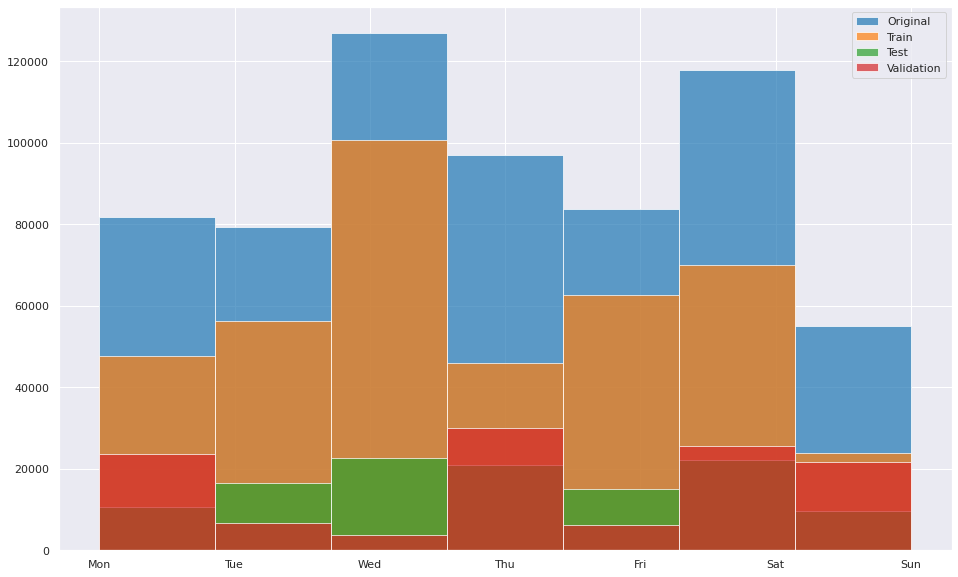

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("tab10")
df["weekday"] = df.timestamp.dt.strftime('%a')
train_df["weekday"] = train_df.timestamp.dt.strftime('%a')
test_df["weekday"] = test_df.timestamp.dt.strftime('%a')
val_df["weekday"] = val_df.timestamp.dt.strftime('%a')

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
ax.hist(df["weekday"], 7, alpha=0.7);
ax.hist(train_df["weekday"], 7, alpha=0.7);
ax.hist(test_df["weekday"], 7, alpha=0.7);
ax.hist(val_df["weekday"], 7, alpha=0.7);
plt.legend(["Original","Train", "Test", "Validation"]);

df.drop(columns=["weekday"], inplace=True)
train_df.drop(columns=["weekday"], inplace=True)
test_df.drop(columns=["weekday"], inplace=True)
val_df.drop(columns=["weekday"], inplace=True)

### Tarkistetaan vielä, ettei varmasti ole duplikaatteja.

In [21]:
print(len(train_df))
train_df.drop_duplicates(inplace=True)
train_df.reset_index(drop=True)
print(len(train_df))

print(len(val_df))
val_df.drop_duplicates(inplace=True)
val_df.reset_index(drop=True)
print(len(val_df))

print(len(test_df))
test_df.drop_duplicates(inplace=True)
test_df.reset_index(drop=True)
print(len(test_df))

407175
407175
117567
117567
117269
117269


### Jaetaan datasetit

In [22]:
y_train = train_df["value_MenovesiLaskAs"]
X_train = train_df.drop(['value_MenovesiLaskAs', "timestamp"], axis=1)

y_test = test_df["value_MenovesiLaskAs"]
X_test = test_df.drop(['value_MenovesiLaskAs', "timestamp"], axis=1)

y_val = val_df["value_MenovesiLaskAs"]
X_val = val_df.drop(['value_MenovesiLaskAs', "timestamp"], axis=1)

### Tallennetaan tiedostoihin

In [23]:
X_train.to_csv(f"../Datat/csv/X_train.csv", index=False)
y_train.to_csv(f"../Datat/csv/y_train.csv", index=False)
X_val.to_csv(f"../Datat/csv/X_val.csv", index=False)
y_val.to_csv(f"../Datat/csv/y_val.csv", index=False)
X_test.to_csv(f"../Datat/csv/X_test.csv", index=False)
y_test.to_csv(f"../Datat/csv/y_test.csv", index=False)